In [ ]:
%load_ext tensorboard
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip freeze --local > /content/gdrive/My\ Drive/colab_installed.txt

Mounted at /content/gdrive


In [ ]:
!pip install stable-baselines[mpi]==2.10.1 --quiet
!pip install pyvirtualdisplay
!pip install procgen --quiet
!pip install gym box2d --quiet

     |████████████████████████████████| 245kB 4.0MB/s 
     |████████████████████████████████| 39.9MB 103kB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 675kB 35.3MB/s 
     |████████████████████████████████| 3.3MB 39.5MB/s 
     |████████████████████████████████| 204kB 46.5MB/s 
     |████████████████████████████████| 40kB 3.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 1.3MB 4.4MB/s 


In [ ]:
import imageio
import time
import numpy as np
import base64
import IPython
import PIL.Image
import pyvirtualdisplay
import gym

# Video 
from pathlib import Path
from IPython import display as ipythondisplay

# Stable baselines

# from stable_baselines.common.policies import CnnPolicy, MlpPolicy #TODO: Replace with IMPALA cnn



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/CSW182 Final')
#sys.path.append('/content/gdrive/Sharedwithme/CSW182 Final')

In [ ]:
from helpers import record
from ImpalaCnn import ImpalaCnn

from stable_baselines import PPO2
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common import make_vec_env
from stable_baselines.common.policies import MlpPolicy, CnnPolicy

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
######### Hyperparameters #########
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack
#logs_base_dir = './runs' # Log DIR
# There already exists an environment generator that will make and wrap atari environments correctly.
env = make_atari_env('PongNoFrameskip-v4', num_env=1, seed=0)

In [ ]:
# hyperparameters from rl-zoo : https://github.com/araffin/rl-baselines-zoo/blob/master/hyperparams/ppo2.yml
Impala_model = PPO2(ImpalaCnn, env, verbose=0, n_steps = 128, nminibatches=8, cliprange = 0.1, cliprange_vf = -1) 
Base_model = PPO2(CnnPolicy, env, verbose=0, n_steps = 128, nminibatches=8, cliprange = 0.1, cliprange_vf = -1) 





Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [ ]:
def run_training(model, steps_per_round=16384,limit=10):
# This function will run a training with value set in `steps_per_round`
# after each round it will measure it's value, If value is under `limit` it will keep training until score limit is reached.  

  steps_total = 0
  score = 0
  best_score = -10000
  best_model = None

  while score < limit:
      steps_total = steps_total + steps_per_round
      model.learn(total_timesteps=steps_per_round)
      new_evaluation = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
      score = new_evaluation[0]
      if score > best_score:
        best_score = score
        best_model = model
        #record(model, length=1000) # won't work
      print('steps_total: ' + str(steps_total))
      print("Mean reward:", score )
    

  # Threshold reached > evaluate over 100 episodes > Video rec/display
  print("Reward limit achived, measuring over 100ep & recording video, please wait...")
  #record(model, length=1000)
  ep100 = evaluate_policy(model, env, n_eval_episodes=100, deterministic=True, render=False, callback=None, reward_threshold=None, return_episode_rewards=False)
  print("Mean Reward 100 Episodes: ", ep100[0])
  #model.save("ppo2_base." + str(steps_total) + "-" + env_id)

In [ ]:
run_training(Base_model, steps_per_round = 100000, limit=20)

KeyboardInterrupt: ignored

In [ ]:
run_training(Impala_model, steps_per_round = 100000, limit=20)

steps_total: 100000
Mean reward: -20.01
steps_total: 200000
Mean reward: -15.76
steps_total: 300000
Mean reward: -9.25
steps_total: 400000
Mean reward: -14.91
steps_total: 500000
Mean reward: -3.14
steps_total: 600000
Mean reward: -3.02
steps_total: 700000
Mean reward: 2.41
steps_total: 800000
Mean reward: -1.67
steps_total: 900000
Mean reward: 5.56
steps_total: 1000000
Mean reward: 19.56


Text(0, 0.5, 'Mean Reward over 100 episodes')

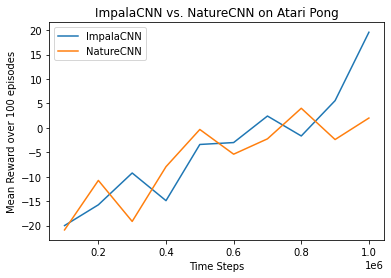

In [ ]:
import matplotlib.pyplot as plt
impala_score = [-20.01, -15.76, -9.25, -14.91, -3.41, -3.02, 2.41, -1.67, 5.56, 19.56]
base_cnn_score = [-20.9, -10.77, -19.16, -7.96, -0.34, -5.4, -2.26, 4, -2.4, 2]
time = [100000,200000,300000,400000,500000,600000,700000, 800000, 900000, 1000000]

plt.plot(time, impala_score)
plt.plot(time, base_cnn_score)
plt.legend(['ImpalaCNN', 'NatureCNN'])
plt.title('ImpalaCNN vs. NatureCNN on Atari Pong')
plt.xlabel('Time Steps')
plt.ylabel('Mean Reward over 100 episodes')